<a href="https://colab.research.google.com/github/RachanaAcharya18/Deep_workshop/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd


In [ ]:
!pip install tenserflow
!pip install keras

ERROR: Could not find a version that satisfies the requirement tenserflow (from versions: none)
ERROR: No matching distribution found for tenserflow


In [ ]:
from ast import increment_lineno
from os import ST_NOSUID
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation,Dropout,BatchNormalization,Flatten,Dense,AvgPool2D,MaxPool2D
from keras.optimizers import Adam,SGD,RMSprop
import tensorflow as tf
from tensorflow.keras import regularizers # Import regularizers
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import matplotlib.image as mpimg

import plotly.offline as py
import plotly.express as px
import prophet
from prophet.plot import plot_plotly,add_changepoints_to_plot

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rachanakacharya","key":"b6950f4a72cdf0a07c071a6632391ed3"}'}

In [ ]:
import zipfile
os.makedirs("/root/.kaggle",exist_ok=True)

In [ ]:
!mv kaggle.json /root/.kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:21<00:00, 245MB/s]
100% 2.29G/2.29G [00:21<00:00, 116MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip -d chest_xray_data

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NO

In [ ]:
data="/content/chest_xray_data/chest_xray/"

In [ ]:
os.listdir(data)

['__MACOSX', 'test', 'train', 'val', 'chest_xray']

In [ ]:
!rm -r /content/chest_xray_data/chest_xray/__MACOSX
!rm -r /content/chest_xray_data/chest_xray/chest_xray/test
!rm -r /content/chest_xray_data/chest_xray/chest_xray/train
!rm -r /content/chest_xray_data/chest_xray/chest_xray/val
!rm -r /content/chest_xray_data/chest_xray/chest_xray

In [ ]:
data_dir="/content/chest_xray_data/chest_xray/train"
train_datasets=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     image_size=(150,150),
                                                     batch_size=16)

Found 5216 files belonging to 2 classes.


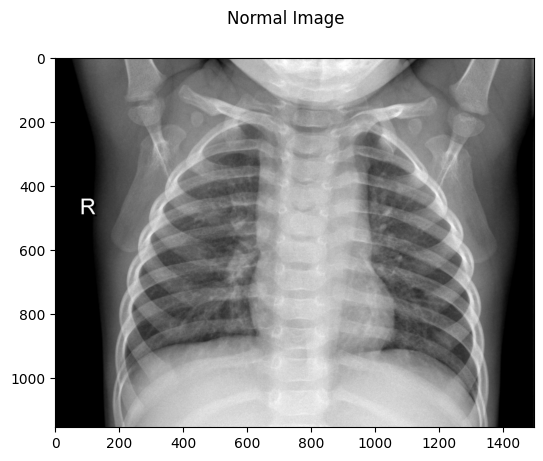

In [ ]:
normal_images = []
for img_path in glob.glob(data + '/train/NORMAL/*'):
  normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('Normal Image')
plt.imshow(normal_images[0],cmap='gray')

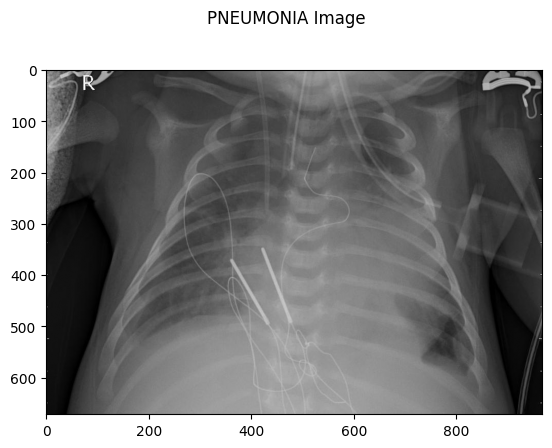

In [ ]:
pneumonia_images = []
for img_path in glob.glob(data + '/train/PNEUMONIA/*'):
  pneumonia_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('PNEUMONIA Image')
plt.imshow(pneumonia_images[0],cmap='gray')

In [ ]:
Image_Width=150
Image_Height=150
Channels=3
INPUT_SHAPE=(Image_Width,Image_Height,Channels)
NR_CLASSES=2
EPOCHS=30
BATCH_SIZE=6

In [ ]:
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE,
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Optional: model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Optional: model.add(Dropout(0.25))

model.add(Flatten())

# Fully Connected Layers
model.add(Dense(128, activation='relu',
                kernel_regularizer=regularizers.l2(0.001))) # Added L2 regularization
model.add(Dropout(0.7))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,377 (18.42 MB)

 Trainable params: 4,828,929 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

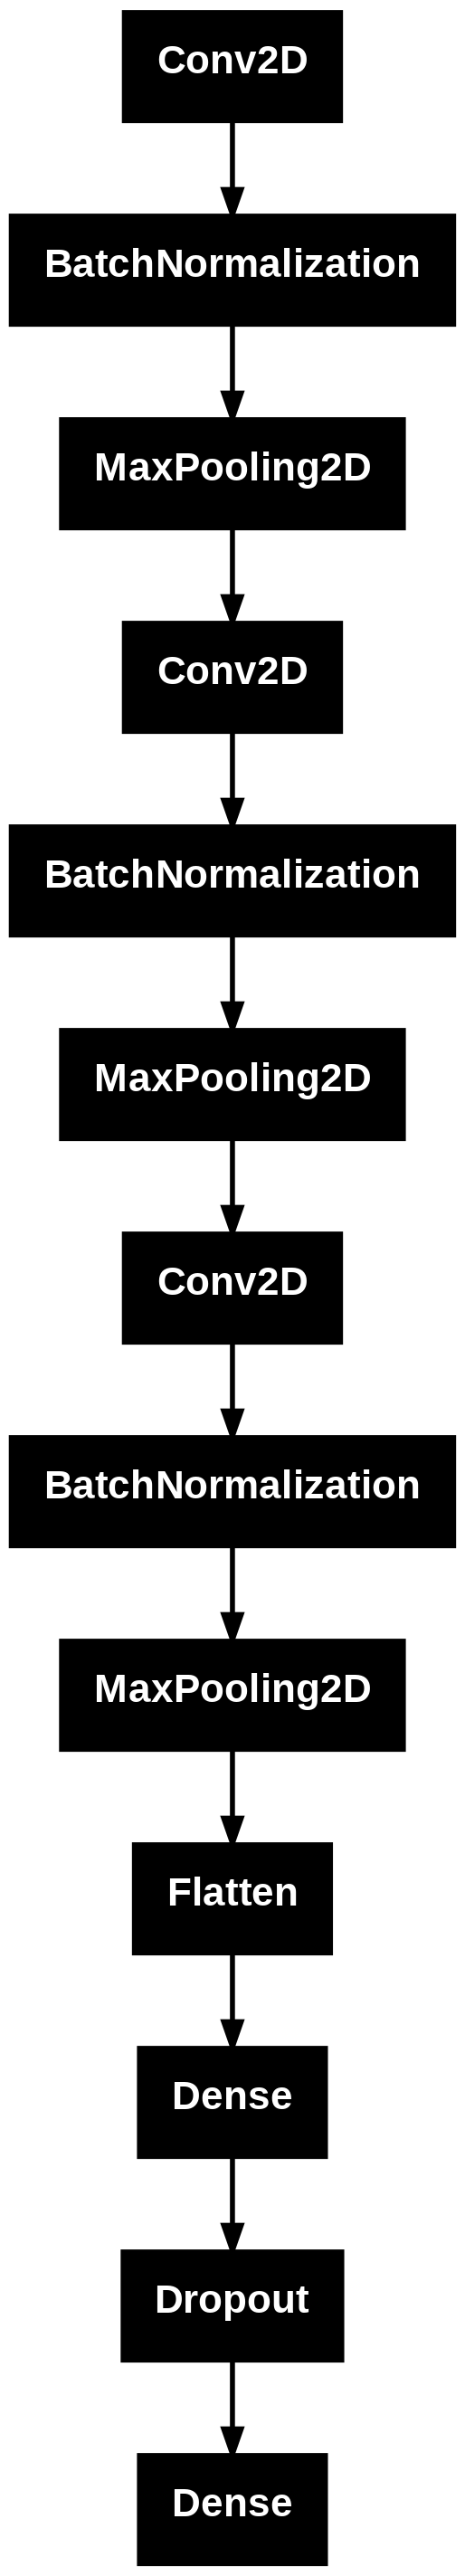

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model.png')

In [ ]:
train_dir = "/content/chest_xray_data/chest_xray/train"
val_dir = "/content/chest_xray_data/chest_xray/val"
test_dir = "/content/chest_xray_data/chest_xray/test"

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=16,
    label_mode='binary'  # use 'categorical' only if you want one-hot vectors
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(150, 150),
    batch_size=16,
    label_mode='binary'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=16,
    label_mode='binary'
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
train_image_count=5216
val_image_count=16

steps_per_count=train_image_count//BATCH_SIZE
validation_steps=val_image_count//BATCH_SIZE

In [ ]:
early_stoping=EarlyStopping(monitor='val_loss',
                            patience=10,
                            restore_best_weights=True,
                            verbose=1)

In [ ]:
history=model.fit(train_dataset,
                  steps_per_epoch=steps_per_count,
                  epochs=EPOCHS,
                  validation_data=val_dataset,
                  validation_steps=validation_steps)

Epoch 1/30
326/869 ━━━━━━━━━━━━━━━━━━━━ 51s 95ms/step - accuracy: 0.8480 - loss: 1.5516

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



869/869 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.8720 - loss: 1.2499 - val_accuracy: 0.7500 - val_loss: 1.2021
Epoch 2/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.9003 - loss: 0.7626 - val_accuracy: 0.7500 - val_loss: 2.1766
Epoch 3/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9159 - loss: 0.6531 - val_accuracy: 0.6875 - val_loss: 1.3950
Epoch 4/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.9222 - loss: 0.7200 - val_accuracy: 0.8125 - val_loss: 0.7992
Epoch 5/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9302 - loss: 0.5928 - val_accuracy: 0.8125 - val_loss: 0.6446
Epoch 6/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9366 - loss: 0.6487 - val_accuracy: 0.5000 - val_loss: 13.7251
Epoch 7/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.9336 - loss: 0.6726 - val_accuracy: 0.8125 - val_loss: 0.9856
Epoch 8/30
869/869 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9464 - loss: 0.5892 - val_accura

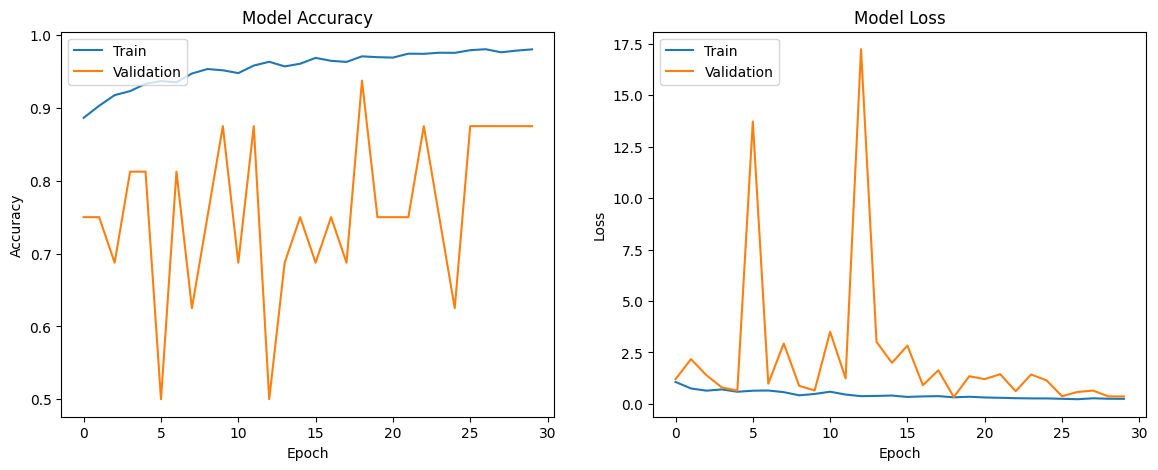

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train','Validation'],loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train','Validation'],loc='upper left')

In [ ]:
print("Training accuracy",history.history['accuracy'][-1]*100)
print("Validation accuracy",history.history['val_accuracy'][-1]*100)

Training accuracy 98.04447889328003
Validation accuracy 87.5


In [ ]:
class_names=val_dataset.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
true_labels=[]
for images,labels in val_dataset:
    true_labels.extend(labels.numpy())
true_labels=np.array(true_labels)

In [ ]:
predictions=model.predict(val_dataset)
predicted_classes=(predictions>0.5).astype("int32").flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


In [ ]:
predicted_labels=[class_names[i] for i in predicted_classes]
true_labels_names=[class_names[int(i)] for i in true_labels]

/tmp/ipython-input-1067088575.py:2: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [ ]:
print(predicted_labels[:10])
print(true_labels_names[:10])

['NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL']
['NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL']


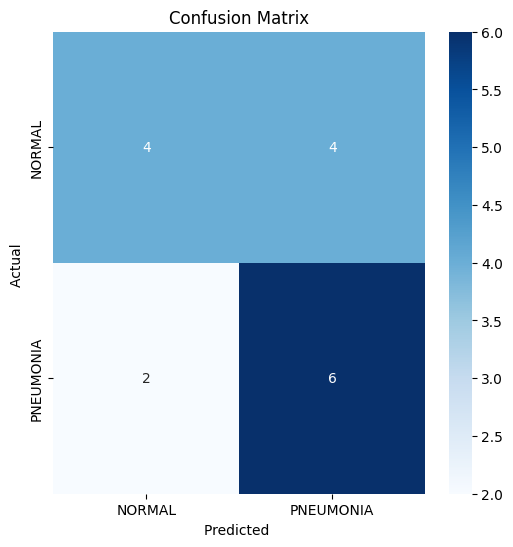

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,6))
cf=confusion_matrix(true_labels_names,predicted_labels)
sns.heatmap(cf,annot=True,fmt='',
            cmap='Blues',
            linecolor='black',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted ')
plt.ylabel('Actual ')
plt.show()


In [ ]:
pred_class=np.array(predicted_labels)

In [ ]:
label_map={'NORMAL':0, 'PNEUMONIA':1}

pred_class=np.array([label_map[label] for label in predicted_labels])
true_class=np.array([int(label) for label in true_labels]) # Iterate through flattened array

/tmp/ipython-input-4284918020.py:4: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [ ]:
correct = np.nonzero(pred_class == true_class)[0]
correct = np.nonzero(pred_class == true_class)[0]
accuracy = len(correct)/len(true_class)
print(f"Accuracy:{accuracy:.4f}")

Accuracy:0.6250


In [ ]:
val_images=[]
val_labes=[]
for img,label in val_dataset.unbatch().take(100):
    val_images.append(img.numpy())
    val_labes.append(label.numpy())


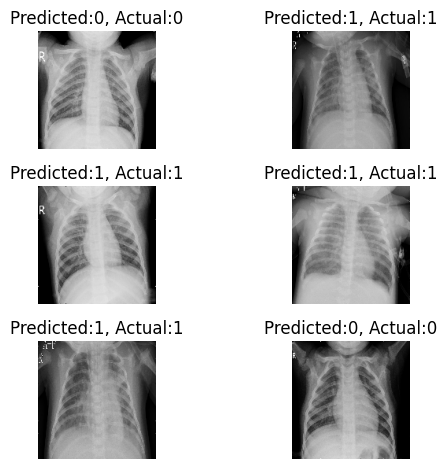

In [ ]:
i=0
for c in correct[:6]:
  plt.subplot(3, 2, i + 1) # Changed to specify subplot grid and index
  plt.imshow(val_images[c].astype("uint8")) # Corrected typo
  plt.title("Predicted:{}, Actual:{}".format(pred_class[c],true_class[c])) # Changed to title
  plt.axis('off')
  i+=1
plt.tight_layout()
plt.show()

In [ ]:
model.save('pneumonia_model.h5')